## Engineering Notebook

---

In this notebook, we analyze the extracted features, assessing the necessity of normalization. We also investigate possible feature selection techniques to reduce the dimensionality of the data.
The sections are organized as follows:

1. [Load Data](#Load-Data)
2. [Feature Analysis](#2.-Feature-Analysis)
3. [Feature Selection](#3.-Feature-Selection)
4. [Feature Normalization](#4.-Feature-Normalization)


In [64]:
# import all the functions
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd

from scipy.stats import spearmanr

### 1. Load Data <a id='Load-Data'></a>


In [65]:
# paths to the features and the labels
FEATURES_RAW_DIR = "../features/raw/"

In [66]:
names = os.listdir(FEATURES_RAW_DIR)
name_labels = {}
data_list = []
data_list_name = []

for name in names:
    data = np.load(FEATURES_RAW_DIR + name)
    X = data["X"]
    y = data["y"].reshape(-1, 1)
    filename = data["filename"].reshape(-1, 1)

    # update dictionary
    name_labels[name.split("_")[0]] = y[0, 0]

    data = np.concatenate((X, y), axis=1)
    data_name = np.concatenate((data, filename), axis=1)
    data_list.append(data)
    data_list_name.append(data_name)

# sort the name_labels dictionary by the labels
name_labels = dict(sorted(name_labels.items(), key=lambda item: item[1]))

# create the full data matrix
data = np.concatenate(data_list, axis=0)
data_name = np.concatenate(
    data_list_name, axis=0
)  # data with the index of the filename in the last column

data_df = pd.DataFrame(data)

### 2. Feature Analysis


#### 2.1. Visualize Features


In [67]:
data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,5681.0,-349.530394,170.782002,-1131.369385,-493.868927,-285.770935,-218.800598,68.951576
1,5681.0,64.244121,56.439627,-147.508499,26.992205,74.836853,106.796501,175.095840
2,5681.0,-22.966034,55.470573,-202.986023,-62.053368,-0.769553,18.862932,73.765327
3,5681.0,14.726614,26.046964,-81.728157,-3.964456,19.284504,33.805252,69.192734
4,5681.0,-9.247497,20.869864,-93.464005,-18.721048,-3.079588,5.599082,52.038036
5,5681.0,7.822334,12.622203,-59.051239,-0.505688,10.359822,17.192474,67.920410
6,5681.0,-10.322080,11.743821,-60.654026,-14.977498,-8.494186,-2.905097,29.086437
7,5681.0,4.769984,12.051124,-50.738564,-3.965688,7.658669,12.899904,52.486908
8,5681.0,-9.263391,11.013362,-61.882683,-11.199246,-6.001773,-2.886022,27.975435
9,5681.0,-0.270526,9.828711,-34.488117,-6.228393,1.394493,5.054112,40.268581


#### 2.2. Feature Correlation


Test Normalità


In [68]:
import scipy.stats as stats

p_values = []
test_val = []

# Calcola il test di normalità per ciascuna colonna del dataframe
for column in data_df.columns:
    test = stats.normaltest(data_df[column])
    p_values.append(test[1])
    test_val.append(test[0])

# Crea un dataframe contenente i risultati del test di normalità
norm_df = pd.DataFrame(
    {"Feature": data_df.columns, "D'Agostino-Pearson": test_val, "P-value": p_values}
)

norm_df.set_index("Feature", inplace=True)


# Definisci una funzione per colorare le celle in base al p-value
def color_cells(val):
    color = (
        "green" if val >= 0.05 else "red"
    )  # Assumendo un livello di significatività del 0.05
    if val > 1:
        color = None
    return "background-color: %s" % color


# Applica la funzione di colorazione al DataFrame
styled_norm_df = norm_df.style.applymap(color_cells)

styled_norm_df

/tmp/ipykernel_1025640/3873497847.py:31: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_norm_df = norm_df.style.applymap(color_cells)


,D'Agostino-Pearson,P-value
Feature,,
0,503.377793,0.000000
1,582.775777,0.000000
2,623.379603,0.000000
3,291.253779,0.000000
4,963.062912,0.000000
5,364.435762,0.000000
6,340.561818,0.000000
7,221.672841,0.000000
8,1686.495266,0.000000


Compute the correlation coefficient between the features and the target variable.


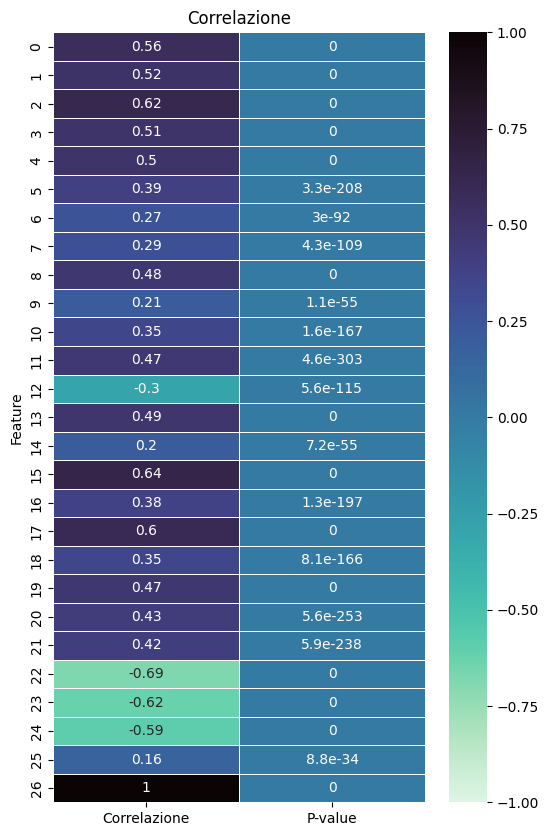

In [69]:
from scipy.stats import spearmanr
import seaborn as sns

# Importa le librerie necessarie
p_values = []
correlazione = []
features = []
# Calcola i coefficienti di correlazione di Kendall e i valori p per ogni coppia di colonne nel dataframe
for col1 in data_df.columns:
    correlation, p_value = spearmanr(data_df[col1], data_df[26])
    p_values.append(p_value)
    correlazione.append(correlation)
    features.append(col1)

correlazione_df = pd.DataFrame(
    {"Feature": features, "Correlazione": correlazione, "P-value": p_values}
)

correlazione_df.set_index("Feature", inplace=True)
plt.figure(figsize=(6, 10))
sns.heatmap(correlazione_df, annot=True, cmap="mako_r", linewidths=0.5, vmax=1, vmin=-1)
plt.title("Correlazione")
plt.show()

Plot correlation matrix  
Since there are a lot of features, it's quite confusing and difficult to analyze the whole correlation matrix. So, whe split the covariance matrix into three parts: first 10 features, next 10 features, and the rest of the features, in all groups is present the target variable as the last column.


In [97]:
def print_correlation(data_df, title):
    plt.figure(figsize=(20, 9))
    sns.set_theme(context="paper", font_scale=1.4)
    plt.suptitle(
            title, x=0.5, y=1, fontsize=22, color="black"
        )
    # Step 3: Calcola i coefficienti di correlazione di Spearman e i valori p
    correlation_matrix = pd.DataFrame(
        index=data_df.columns, columns=data_df.columns, dtype=float
    )
    p_values = pd.DataFrame(index=data_df.columns, columns=data_df.columns, dtype=float)

    # Calcola i coefficienti di correlazione di Spearman e i valori p per ogni coppia di colonne nel dataframe
    for col1 in data_df.columns:
        for col2 in data_df.columns:
            correlation, p_value = spearmanr(data_df[col1], data_df[col2])
            correlation_matrix.loc[col1, col2] = correlation
            p_values.loc[col1, col2] = p_value

    # Step 4: Visualizza la matrice di correlazione

    # Visualizza la matrice di correlazione
    plt.subplot(1, 2, 1)
    sns.heatmap(correlation_matrix, annot=True, cmap="viridis", linewidths=0.5)
    plt.title("Spearman correlation", fontsize=16, color="black")

    # Visualizza i p-value
    plt.subplot(1, 2, 2)
    sns.heatmap(p_values, annot=True, cmap="viridis_r", fmt=".2f",linewidths=0.5,cbar=False)
    plt.title("P-value", fontsize=16, color="black")

    plt.tight_layout()  # This will adjust subplots to fit into figure area.
    plt.show()

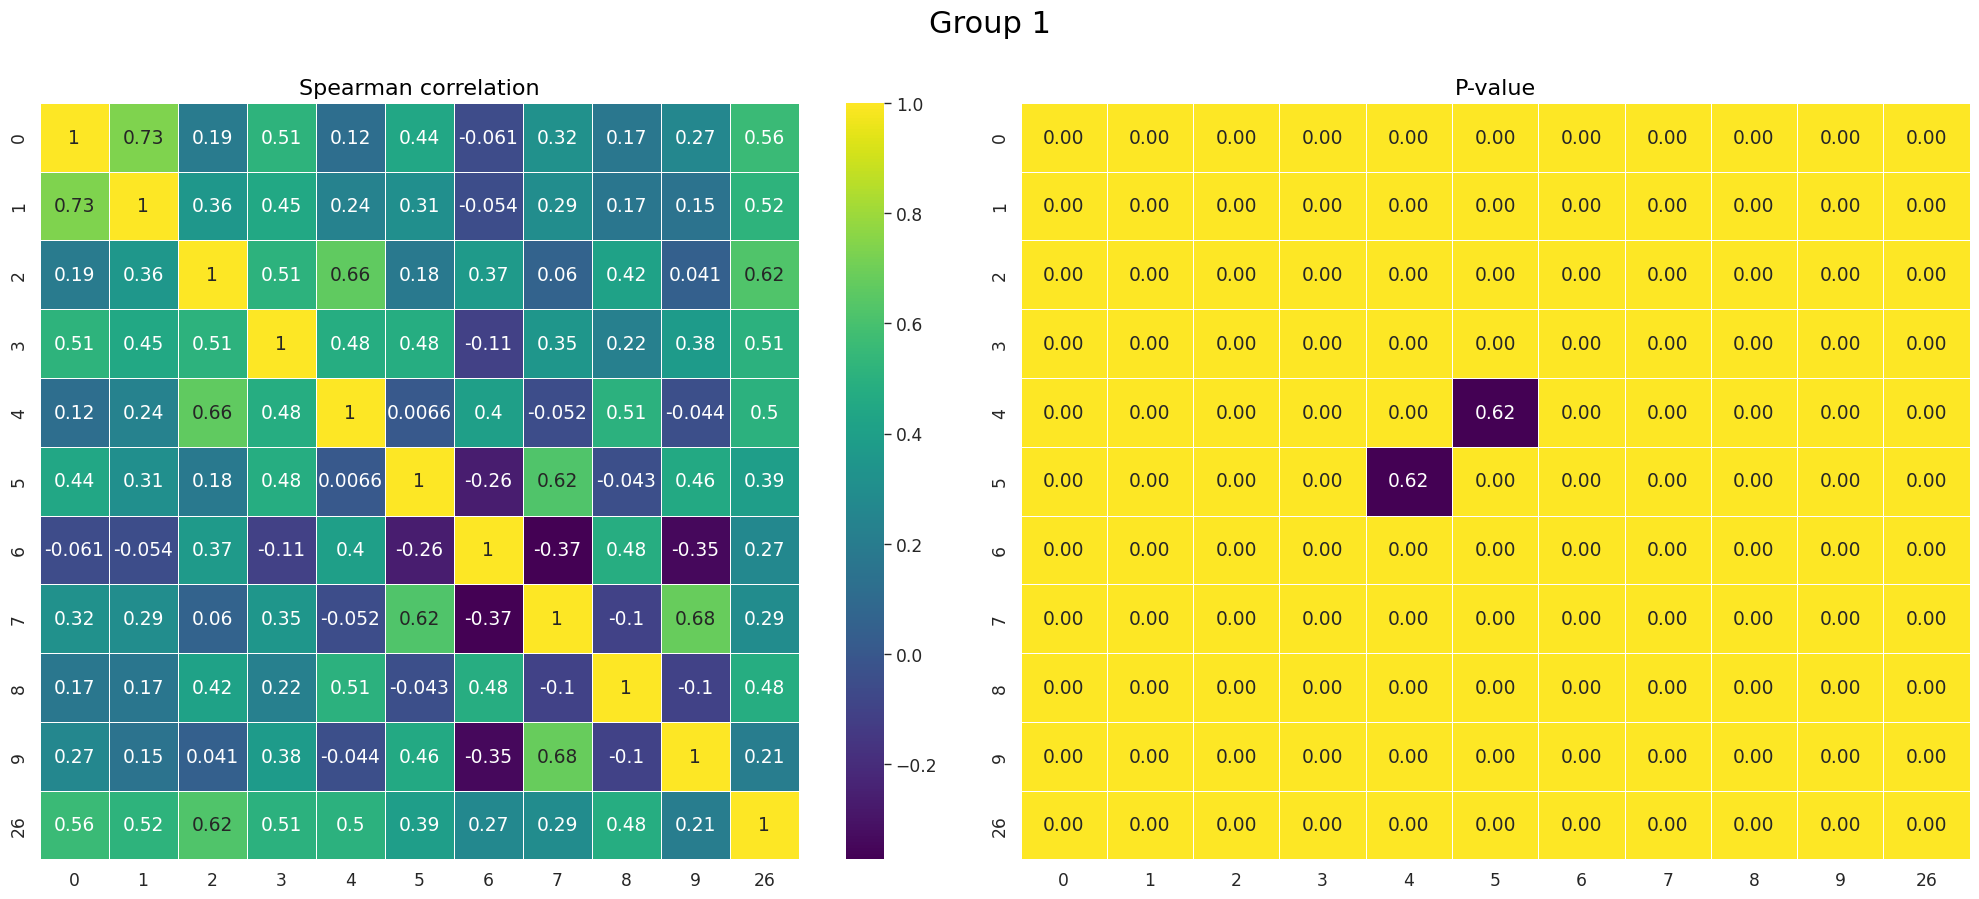

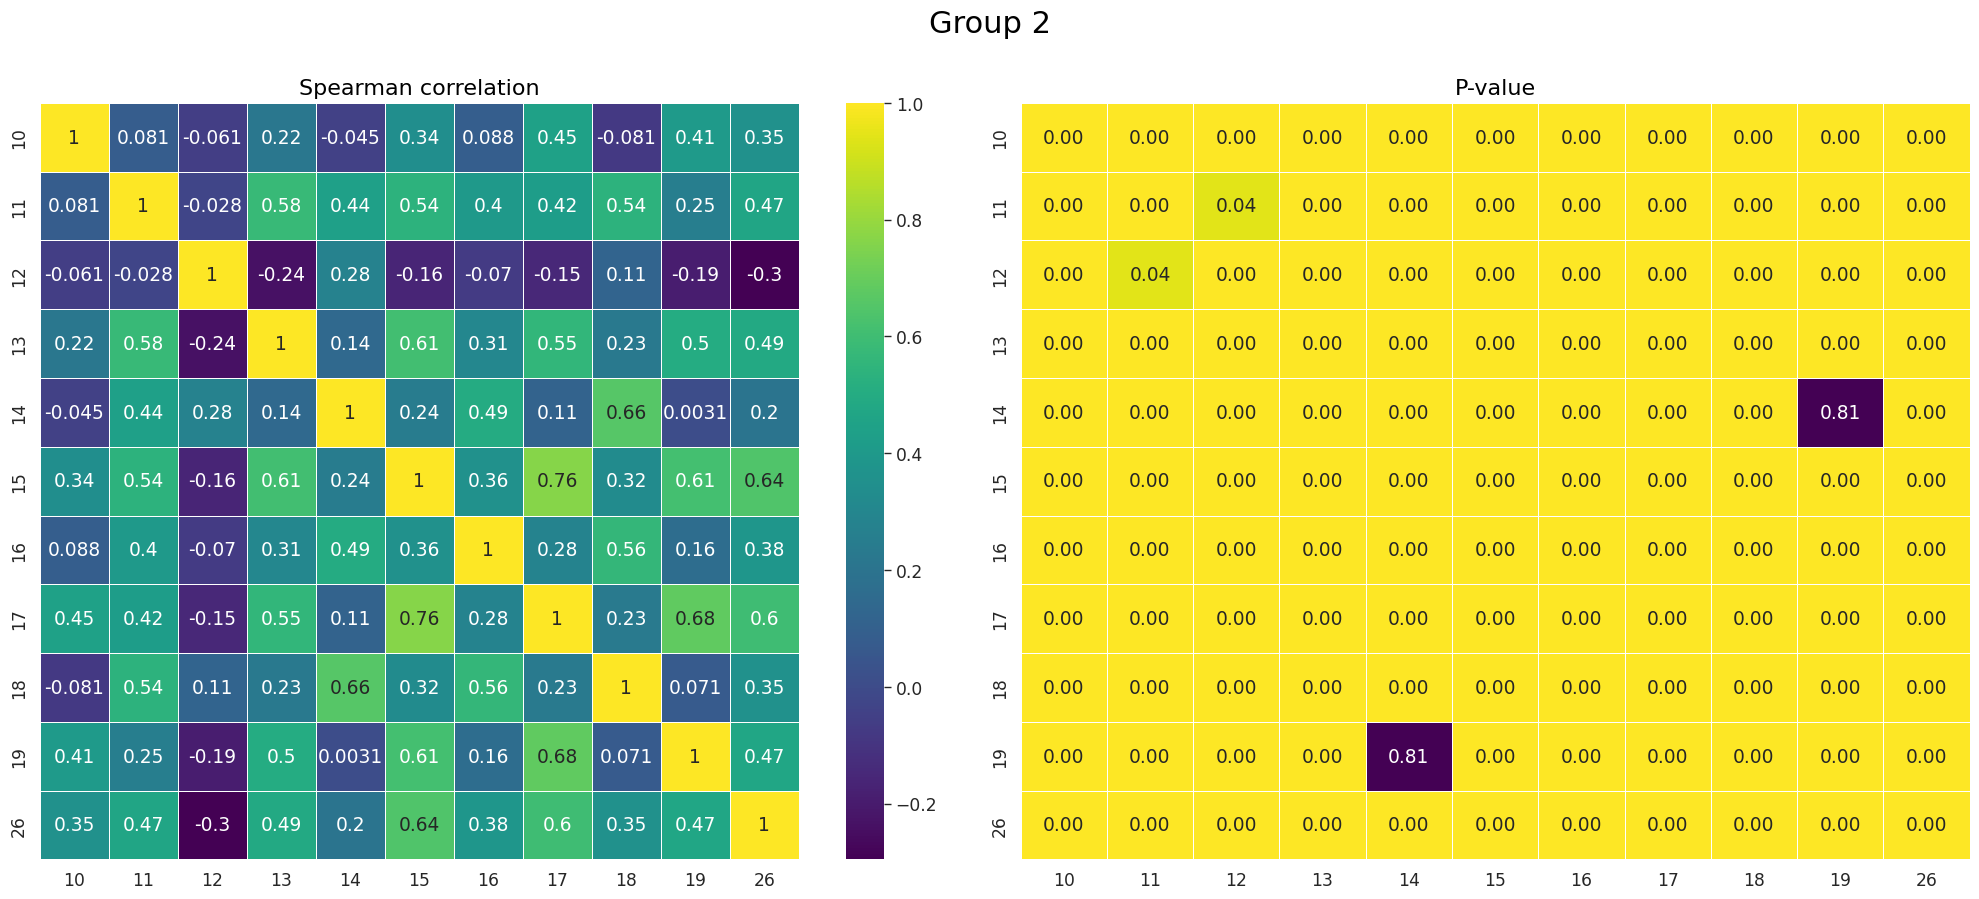

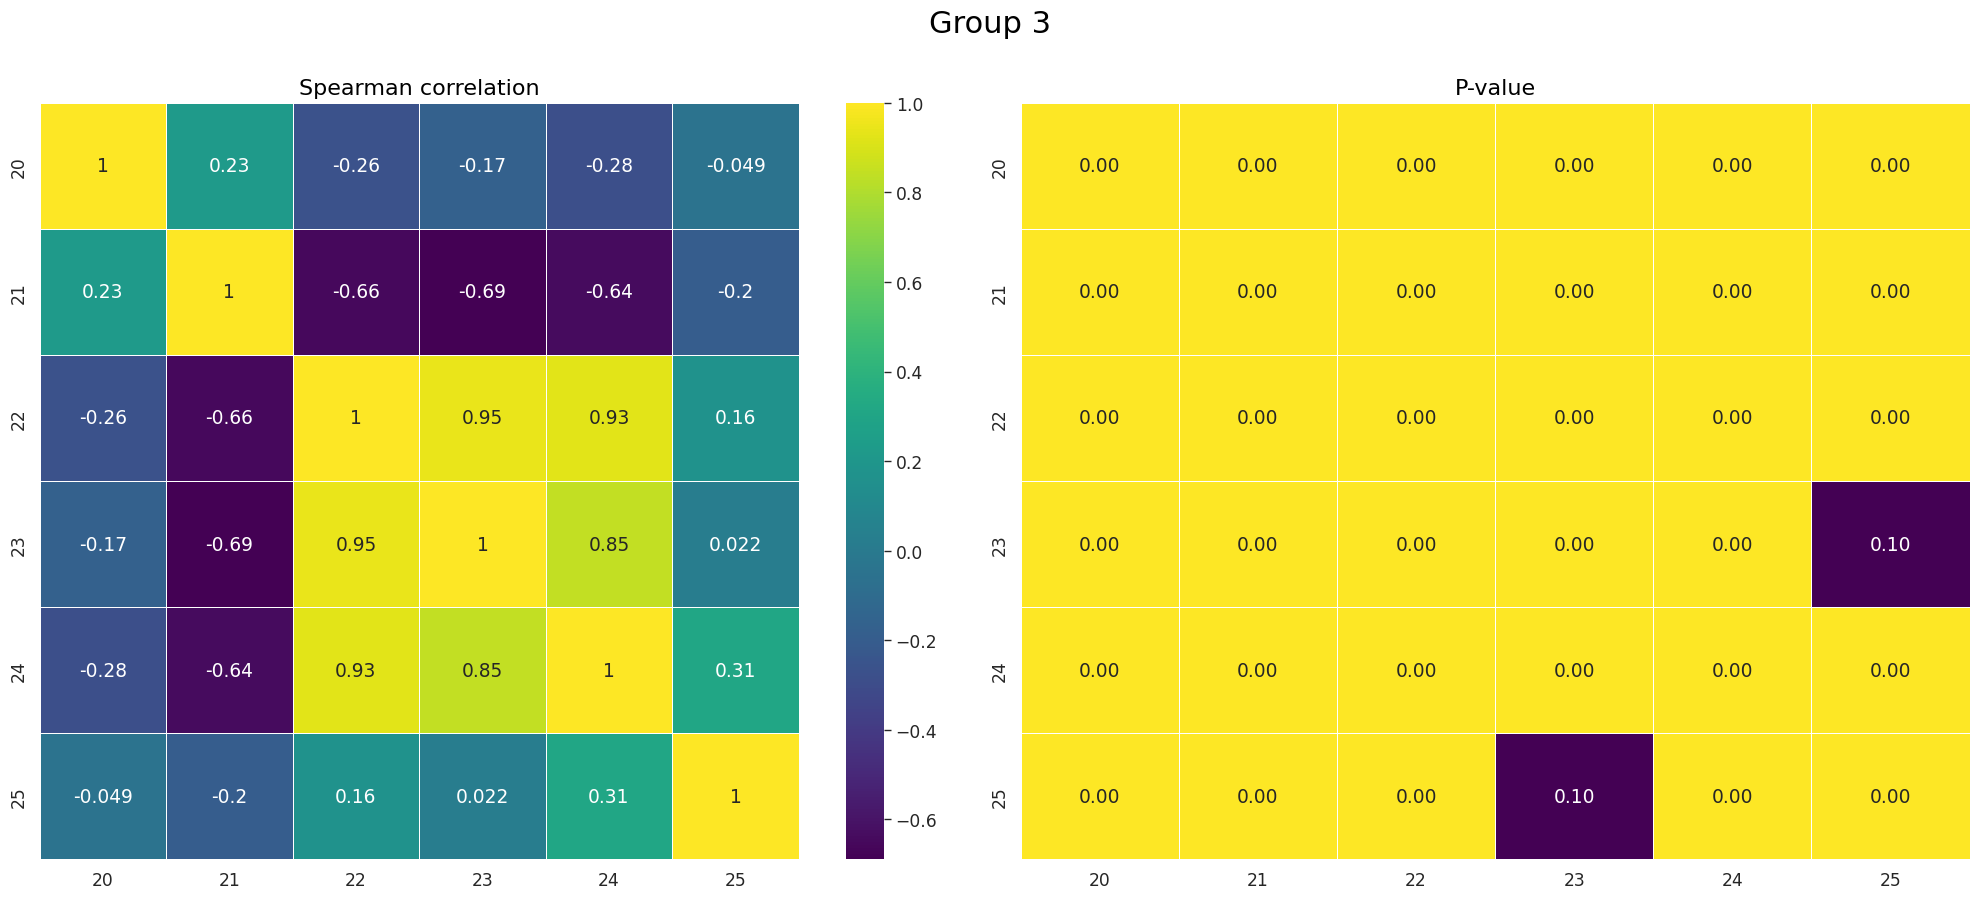

In [98]:
# Importa le librerie necessarie

columns1 = [i for i in range(0, 10)]
columns1.append(26)

columns2 = [i for i in range(10, 20)]
columns2.append(26)

columns3 = [i for i in range(20, 26)]

group1 = data_df[columns1]
group2 = data_df[columns2]
group3 = data_df[columns3]

print_correlation(group1, "Group 1")
print_correlation(group2, "Group 2")
print_correlation(group3, "Group 3")

### 3. Feature Selection <a id='Feature-Selection'></a>


### 4. Feature Normalization
